In [1]:
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2

!pip list | grep epi_to_express  # Make sure you have the project installed as editable library

# if you do not have it installed yet, run
#import os
#os.chdir('/rds/general/project/neurogenomics-lab/live/Projects/epi_to_express') #need to change to parent directory..
#!pip install -e .
# in the parent directory of the model

In [6]:
"""Main module to load and train the model. This should be the program entry point."""
#generic imports
import os
import pathlib
import random
from datetime import datetime
import time
import numpy as np
import pandas as pd
import math

#import constants
from epi_to_express.constants import (
    CHROM_LEN, 
    CHROMOSOMES, 
    SAMPLES,
    CHROMOSOME_DATA,
    SRC_PATH,
    ASSAYS,
    DATA_PATH)

#model imports
import tensorflow as tf
#data loading imports
from epi_to_express.utils import(
    train_valid_split,
    DataGenerator)

# Set random seeds.
np.random.seed(101)
tf.random.set_seed(101)
random.seed(101)

SAVE_PATH = pathlib.Path("./model_results")
SAVE_PATH.mkdir(parents=True, exist_ok=True)

MOD_SAVE_PATH = pathlib.Path("./model_results/models")
MOD_SAVE_PATH.mkdir(parents=True, exist_ok=True)

# 1. --- SETUP PARAMETERS ------------------------------------------------

#what will be used to predict expression
features = ["h3k27ac"]#[ASSAYS[0]]#h3k36me3
#what cell will we predict in
cell = ["K562"]#[SAMPLES[0]]
#resolution for training assay
pred_resolution = 25
# 1 Mb of the assay will be considered for the prediction of gene expression
window_size = 100_000#1_000_000

# Model specifics
batch_size = 128#256#128
n_epochs = 100
#steps_per_epoch = 64
init_learning_rate = 0.001
lr_decay_factor = 0.2
lr_patience = 3
es_patience = 12

# Dataset parameters
valid_frac = 0.2
# Generic split func - Train test split over chromosomes
split = "CHROM"
# Exclude chromosomes, save for test set (when not predicting across cell types)
# hold out chromosomes 3,7,20
blind_test = [2,6,19]#positions not chroms
train_len = np.delete(CHROM_LEN, blind_test)
train_chrom = np.delete(CHROMOSOMES, blind_test)
test_len = CHROM_LEN[np.ix_(blind_test)]
test_chrom = CHROMOSOMES[np.ix_(blind_test)]
train_valid_samples = np.asarray(cell)

#Split the data into training and validation set - split by mix chrom and sample
#set seed so get the same split
(s_train_index, s_valid_index, c_train_index, c_valid_index, s_train_dist,
 s_valid_dist, c_train_dist, c_valid_dist) = train_valid_split(train_chrom,
                                                            train_len,
                                                            train_valid_samples,
                                                            valid_frac,
                                                            split)
# Training
train_cells = train_valid_samples[np.ix_(s_train_index)]
train_chromosomes = CHROMOSOMES[np.ix_(c_train_index)]
train_cell_probs = s_train_dist # equal probabilities
train_chromosome_probs = c_train_dist #weighted by chrom size
# Validation
#using wandb.config. converted their class (v 0.12.9, issue raised) so not storing for now
valid_cells = train_valid_samples[np.ix_(s_valid_index)]
valid_chromosomes = CHROMOSOMES[np.ix_(c_valid_index)]
valid_cell_probs = s_valid_dist
valid_chromosome_probs = c_valid_dist

# 2. --- Data loaders ---------------------------------------------------
training_generator = DataGenerator(cell=train_cells, 
                                   chromosomes=train_chromosomes,
                                   features=features, 
                                   window_size=window_size,
                                   pred_res=pred_resolution, 
                                   batch_size=batch_size, shuffle=True,
                                   test_subset=False)
validation_generator = DataGenerator(cell=valid_cells, 
                                   chromosomes=valid_chromosomes,
                                   features=features, 
                                   window_size=window_size,
                                   pred_res=pred_resolution,
                                   batch_size=batch_size, shuffle=True,
                                   test_subset=False)


In [7]:
print(features)
print(cell)

['h3k27ac']
['K562']


In [8]:
# 3. --- Training ---------------------------------------------------
from epi_to_express.model import conv_profile_task_base

# import conv model
model = conv_profile_task_base(input_shape=[window_size//pred_resolution,len(features)],
                               output_shape=[1,1])

#learning rate schedule
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                                 factor=lr_decay_factor, 
                                                 patience=lr_patience)
#early stopping
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=es_patience,
                                      #save best weights
                                      restore_best_weights=True)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=init_learning_rate),
              loss=tf.keras.losses.mean_squared_error,
              metrics='mse')

In [ ]:
#diff at 10k
#diff at 20k
#diff at 50k
#diff at 100k

In [12]:
#h3k36me3
# Train model on dataset
model.fit(training_generator,
          validation_data=validation_generator,
          epochs=n_epochs,
          #steps_per_epoch=steps_per_epoch,
          verbose=2,
          use_multiprocessing=False,#started getting errors when set to True...
          callbacks=[es,lr_schedule]
         )

Epoch 1/100
60/60 - 216s - loss: 1.4463 - mse: 1.4463 - val_loss: 0.1010 - val_mse: 0.1010 - lr: 0.0010 - 216s/epoch - 4s/step
Epoch 2/100
60/60 - 210s - loss: 1.3371 - mse: 1.3371 - val_loss: 0.0932 - val_mse: 0.0932 - lr: 0.0010 - 210s/epoch - 3s/step
Epoch 3/100
60/60 - 208s - loss: 1.3100 - mse: 1.3100 - val_loss: 0.0921 - val_mse: 0.0921 - lr: 0.0010 - 208s/epoch - 3s/step
Epoch 4/100
60/60 - 205s - loss: 1.2966 - mse: 1.2966 - val_loss: 0.0918 - val_mse: 0.0918 - lr: 0.0010 - 205s/epoch - 3s/step
Epoch 5/100
60/60 - 204s - loss: 1.2811 - mse: 1.2811 - val_loss: 0.1009 - val_mse: 0.1009 - lr: 0.0010 - 204s/epoch - 3s/step
Epoch 6/100
60/60 - 202s - loss: 1.2783 - mse: 1.2783 - val_loss: 0.0925 - val_mse: 0.0925 - lr: 0.0010 - 202s/epoch - 3s/step
Epoch 7/100
60/60 - 203s - loss: 1.2609 - mse: 1.2609 - val_loss: 0.0949 - val_mse: 0.0949 - lr: 0.0010 - 203s/epoch - 3s/step
Epoch 8/100
60/60 - 201s - loss: 1.1432 - mse: 1.1432 - val_loss: 0.0925 - val_mse: 0.0925 - lr: 2.0000e-04 - 2

In [5]:
#h3k36me3
#128 batch
# Train model on dataset
model.fit(training_generator,
          validation_data=validation_generator,
          epochs=n_epochs,
          #steps_per_epoch=steps_per_epoch,
          verbose=2,
          use_multiprocessing=False,#started getting errors when set to True...
          callbacks=[es,lr_schedule]
         )

Epoch 1/100


2022-06-07 08:51:44.364608: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-06-07 08:51:45.201832: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-06-07 08:51:45.380324: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


121/121 - 208s - loss: 1.4076 - mse: 1.4076 - val_loss: 0.0937 - val_mse: 0.0937 - lr: 0.0010 - 208s/epoch - 2s/step
Epoch 2/100
121/121 - 184s - loss: 1.3110 - mse: 1.3110 - val_loss: 0.0895 - val_mse: 0.0895 - lr: 0.0010 - 184s/epoch - 2s/step
Epoch 3/100
121/121 - 180s - loss: 1.2890 - mse: 1.2890 - val_loss: 0.0950 - val_mse: 0.0950 - lr: 0.0010 - 180s/epoch - 1s/step
Epoch 4/100
121/121 - 180s - loss: 1.2777 - mse: 1.2777 - val_loss: 0.0910 - val_mse: 0.0910 - lr: 0.0010 - 180s/epoch - 1s/step
Epoch 5/100
121/121 - 180s - loss: 1.2692 - mse: 1.2692 - val_loss: 0.0925 - val_mse: 0.0925 - lr: 0.0010 - 180s/epoch - 1s/step
Epoch 6/100
121/121 - 181s - loss: 1.2654 - mse: 1.2654 - val_loss: 0.0925 - val_mse: 0.0925 - lr: 2.0000e-04 - 181s/epoch - 1s/step
Epoch 7/100
121/121 - 181s - loss: 1.2655 - mse: 1.2655 - val_loss: 0.0921 - val_mse: 0.0921 - lr: 2.0000e-04 - 181s/epoch - 1s/step
Epoch 8/100
121/121 - 181s - loss: 1.2635 - mse: 1.2635 - val_loss: 0.0916 - val_mse: 0.0916 - lr: 2.

In [16]:
#h3k27ac
# Train model on dataset
model.fit(training_generator,
          validation_data=validation_generator,
          epochs=n_epochs,
          #steps_per_epoch=steps_per_epoch,
          verbose=2,
          use_multiprocessing=False,#started getting errors when set to True...
          callbacks=[es,lr_schedule]
         )

Epoch 1/100
60/60 - 215s - loss: 1.4660 - mse: 1.4660 - val_loss: 0.0945 - val_mse: 0.0945 - lr: 0.0010 - 215s/epoch - 4s/step
Epoch 2/100
60/60 - 209s - loss: 1.3465 - mse: 1.3465 - val_loss: 0.0898 - val_mse: 0.0898 - lr: 0.0010 - 209s/epoch - 3s/step
Epoch 3/100
60/60 - 208s - loss: 1.3212 - mse: 1.3212 - val_loss: 0.0922 - val_mse: 0.0922 - lr: 0.0010 - 208s/epoch - 3s/step
Epoch 4/100
60/60 - 205s - loss: 1.3116 - mse: 1.3116 - val_loss: 0.0910 - val_mse: 0.0910 - lr: 0.0010 - 205s/epoch - 3s/step
Epoch 5/100
60/60 - 203s - loss: 1.3008 - mse: 1.3008 - val_loss: 0.0961 - val_mse: 0.0961 - lr: 0.0010 - 203s/epoch - 3s/step
Epoch 6/100
60/60 - 203s - loss: 1.2980 - mse: 1.2980 - val_loss: 0.0926 - val_mse: 0.0926 - lr: 2.0000e-04 - 203s/epoch - 3s/step
Epoch 7/100
60/60 - 202s - loss: 1.2834 - mse: 1.2834 - val_loss: 0.0929 - val_mse: 0.0929 - lr: 2.0000e-04 - 202s/epoch - 3s/step
Epoch 8/100
60/60 - 202s - loss: 1.1664 - mse: 1.1664 - val_loss: 0.0917 - val_mse: 0.0917 - lr: 2.0000

In [9]:
#h3k27ac
#128 batch size
# Train model on dataset
model.fit(training_generator,
          validation_data=validation_generator,
          epochs=n_epochs,
          #steps_per_epoch=steps_per_epoch,
          verbose=2,
          use_multiprocessing=False,#started getting errors when set to True...
          callbacks=[es,lr_schedule]
         )

Epoch 1/100
121/121 - 200s - loss: 1.4143 - mse: 1.4143 - val_loss: 0.0934 - val_mse: 0.0934 - lr: 0.0010 - 200s/epoch - 2s/step
Epoch 2/100
121/121 - 184s - loss: 1.3212 - mse: 1.3212 - val_loss: 0.0895 - val_mse: 0.0895 - lr: 0.0010 - 184s/epoch - 2s/step
Epoch 3/100
121/121 - 182s - loss: 1.2991 - mse: 1.2991 - val_loss: 0.0928 - val_mse: 0.0928 - lr: 0.0010 - 182s/epoch - 2s/step
Epoch 4/100
121/121 - 180s - loss: 1.2852 - mse: 1.2852 - val_loss: 0.0934 - val_mse: 0.0934 - lr: 0.0010 - 180s/epoch - 1s/step
Epoch 5/100
121/121 - 180s - loss: 1.2739 - mse: 1.2739 - val_loss: 0.0962 - val_mse: 0.0962 - lr: 0.0010 - 180s/epoch - 1s/step
Epoch 6/100
121/121 - 182s - loss: 1.2695 - mse: 1.2695 - val_loss: 0.0932 - val_mse: 0.0932 - lr: 2.0000e-04 - 182s/epoch - 2s/step
Epoch 7/100
121/121 - 182s - loss: 1.2689 - mse: 1.2689 - val_loss: 0.0923 - val_mse: 0.0923 - lr: 2.0000e-04 - 182s/epoch - 2s/step
Epoch 8/100
121/121 - 182s - loss: 1.2669 - mse: 1.2669 - val_loss: 0.0917 - val_mse: 0.0

In [26]:
print(model.predict_on_batch(X).shape)
print(y)
model.predict_on_batch(X)

(4, 1, 1)
[-0.79860288  0.38827886  0.89971109 -0.98716278]


array([[[0.31674972]],

       [[0.31140888]],

       [[0.31504294]],

       [[0.31653702]]], dtype=float32)

ValueError: x and y can be no greater than 2D, but have shapes (3,) and (3, 1, 1)

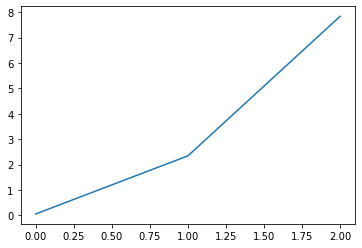

In [119]:
plt.plot(y)
plt.plot(model.predict_on_batch(X))
plt.show()

In [ ]:
model.save(f"{MOD_SAVE_PATH}'/mod_{cell}_{features}")

In [ ]:
pred_resolution = 25
# 1 Mb of the assay will be considered for the prediction of gene expression
window_size = 1_000_000